In [213]:
import os
import tqdm
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import torch
from torch import nn

from torchvision.models import efficientnet, EfficientNet_V2_M_Weights
from torchvision import datasets, transforms

from utils import save_pickle, load_pickle, ImageSearcher

In [17]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
device

'cuda:1'

In [220]:
searcher = ImageSearcher('train')

## Dataset

In [86]:
class ImageLoader(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        files = os.listdir(self.folder)
        self.labels = ['.'.join(e.split('.')[:-1]) for e in files]
        self.files = [os.path.join(folder, f) for f in files]
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        image_path = self.files[idx]
        image = tv.io.read_image(image_path)
        if self.transform is not None:
            image = self.transform(image)
        
        label = self.labels[idx]
        
        return (image, label)

In [87]:
ds = ImageLoader('train')

In [55]:
shapes = [e[0].shape for e in tqdm.tqdm(ds)]

100%|██████████| 9912/9912 [00:32<00:00, 304.96it/s]


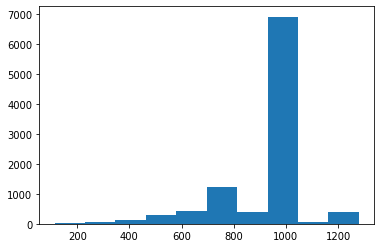

In [61]:
_ = plt.hist([e[1] for e in shapes])

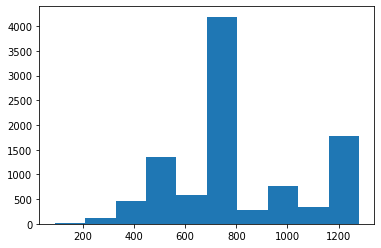

In [62]:
_ = plt.hist([e[2] for e in shapes])

In [104]:
IMAGE_SIZE = 480


ds = ImageLoader(
    folder='train',
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ConvertImageDtype(torch.float32),
    ])
)

In [118]:
loader = torch.utils.data.DataLoader(
    ds,
    64,
)

## Model

In [ ]:
model = efficientnet.efficientnet_v2_m(EfficientNet_V2_M_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Identity()

In [119]:
model = model.to(device)

## Embeddings

### computing embeddings

In [129]:
embs = []
ids = []
for x, y in tqdm.tqdm(loader):
    with torch.no_grad():
        emb = model(x.to(device)).cpu().numpy()
        embs.append(emb)
        ids.append(y)

100%|██████████| 155/155 [07:42<00:00,  2.98s/it]


In [139]:
embs = np.concatenate(embs)
ids = [e for l in ids for e in l]

In [144]:
save_pickle([embs, ids], 'artifacts/embs/efficientnet_v2_m__embs.pkl')

### analyzing embeddings

We can see problem with collage photos:
- there are iamges with different pets
- similar photos in case of collage is a collage even if pets are different

For images with single pet model produce not bad similar items

In [155]:
ids = np.array(ids)

In [152]:
s = cosine_similarity(embs, embs)

In [225]:
top_k = 3
inds = np.argsort(-s, axis=1)[:, :top_k]
pred = ids[inds]

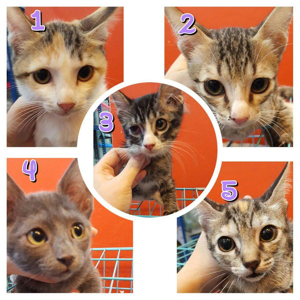

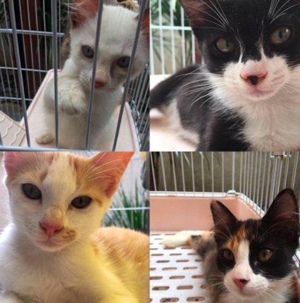

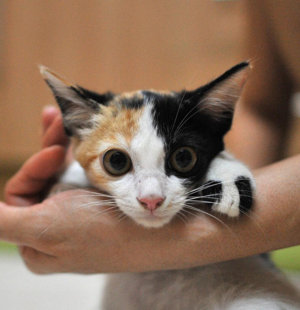

In [230]:
idx = 10
for e in pred[idx]:
    display(searcher.find(e, low_quality=True))

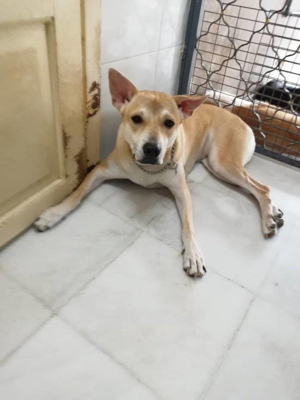

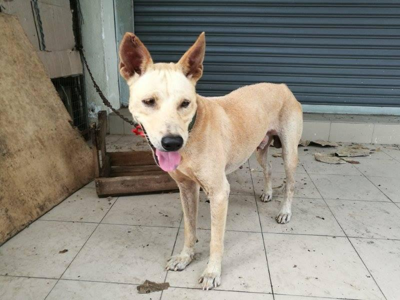

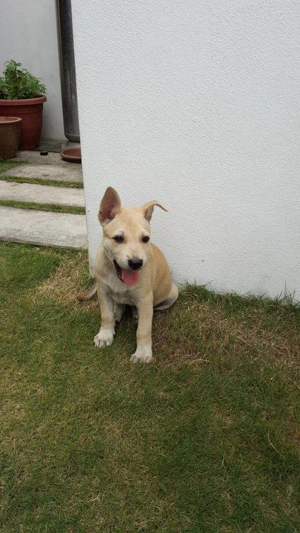

In [231]:
idx = 5
for e in pred[idx]:
    display(searcher.find(e, low_quality=True))

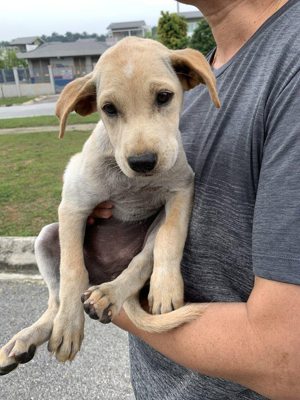

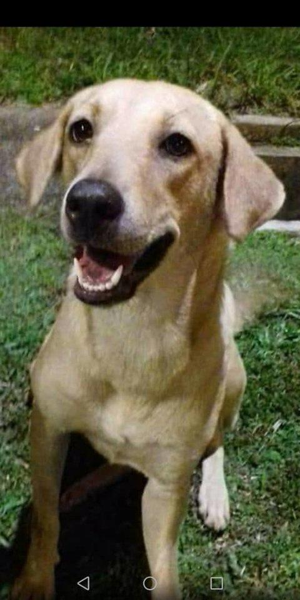

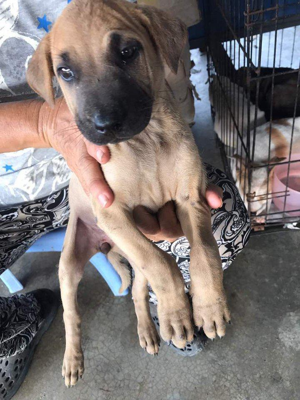

In [232]:
idx = 100
for e in pred[idx]:
    display(searcher.find(e, low_quality=True))